In [96]:
# Importing nessesary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# from random import shuffle
import glob
from PIL import Image
import time
import functools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [112]:
# Loading Images
content_path = '49685490-3b6c5400-fb0a-11e8-876a-526a95591cb5.jpg'
style_path = '49685491-3b6c5400-fb0a-11e8-9161-1c6940d5e6bc.jpg'

cont = Image.open(content_path)
cont = cont.resize((256,256))
sty = Image.open(style_path)
sty = sty.resize((256,256))

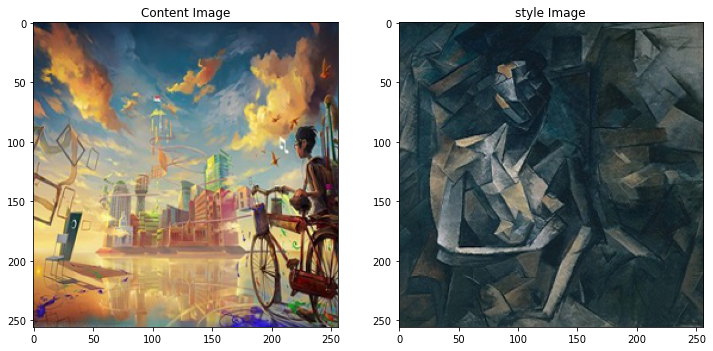

In [113]:
# Displaying images
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(cont)
plt.title("Content Image")

plt.subplot(1,2,2)
plt.imshow(sty)
plt.title("style Image")
plt.show()

In [114]:
# Shape of input image
cont= img_to_array(cont)
cont.shape

(256, 256, 3)

In [115]:
# Defining function to load and preprocess image as per VGG model requirement
def load_img(path_to_img):
    max_dim = 256
    img = Image.open(path_to_img, )
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
#     img = img.resize((512,512),Image.ANTIALIAS)
  
    img = img_to_array(img)
    return img

def preprocess_img(img_path):
    img = load_img(img_path)
    # We need to broadcast the image array such that it has a batch dimension 
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [116]:
# Deprocessing the image format
def deprocess_img(process_img):
    x = process_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, axis = 0)
    assert len(x.shape) == 3  
    if len(x.shape) !=3:
        raise ValueError('Invalid input')
    
    #We will add the individual channel mean.
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    x = x[..., ::-1]             #Converting BGR to RGB
    
    x = np.clip(x, 0, 255).astype('uint8')    #clipping pixel values
    
    return x

In [117]:
# selecting the layers for content and style features
content_layers = ['block5_conv2']
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

In [118]:
# defining the model
def get_model():
    vgg = VGG19(include_top = False, weights = 'imagenet')
    vgg.trainable = False
    
    content_output = [vgg.get_layer(layer).output for layer in content_layers]
    style_output = [vgg.get_layer(layer).output for layer in style_layers]
    output = content_output + style_output
    return Model(inputs = vgg.inputs, outputs = output)

In [119]:
# defining function to calculate content loss
def content_loss(content, base_img):
    return tf.reduce_mean(tf.square(content - base_img))

In [120]:
# defining function to calculate style loss
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    vector = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(vector)[0]
    gram = tf.matmul(vector, vector, transpose_a = True)
    return gram / tf.cast(n, tf.float32)

def style_loss(style, base_img):
    gram_style = gram_matrix(style)
    gram_gen = gram_matrix(base_img)
    return tf.reduce_mean(tf.square(gram_style - gram_gen))

In [121]:
#function for getting output of content and style layers
def get_feature_representation(model, content_path, style_path):
    content_img = preprocess_img(content_path)
    style_img = preprocess_img(style_path)
    
    content_output = model(content_img)
    style_output = model(style_img)
    
    content_features = [content_layer[0] for content_layer in content_output[:len(style_layers)]]
    style_features = [style_layer[0] for style_layer in style_output[len(style_layers):]]
    
    return content_features, style_features

In [122]:
# function for total loss
def compute_loss(model, content_features, style_features, base_img, loss_weights):
    
    content_weight, style_weight = loss_weights    #Also known as alpha and beta
    
    output = model(base_img)
    content_base_features = output[:len(style_layers)]    #feature output of base_img w.r.t. content image
    style_base_features = output[len(style_layers):]    #feature output of base_img w.r.t. style image
    
    content_score, style_score = 0, 0
    
    weights_per_content_layer = 1.0 / float(len(content_layers))       #getting weights from content layer 
    #content_feature is from content image and content_base_feature are from base_img or generated noise(image)
    for content_feature, content_base_feature in zip(content_features, content_base_features):
        content_score += weights_per_content_layer * content_loss(content_feature, content_base_feature[0])
        
    weights_per_style_layer = 1.0 / float(len(style_layers))     #getting equally distributed weights from individual layer
    for style_feature, style_base_feature in zip(style_features, style_base_features):
        style_score += weights_per_style_layer * style_loss(style_feature, style_base_feature[0])
        
    content_score *= content_weight
    style_score *= style_weight
    
    total_loss = content_score + style_score
    return total_loss, content_score, style_score

In [123]:
# backpogation for updating generated image
def compute_grad(args):
    with tf.GradientTape() as grad:
        loss = compute_loss(**args)
    
    gradients = grad.gradient(loss[0], args['base_img'])
    return gradients, loss

In [124]:
def style_transfer(content_path, style_path, epochs, content_weight, style_weight):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False
        
    content_features, style_features = get_feature_representation(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    base_img = preprocess_img(content_path)
    base_img = tf.Variable(base_img, dtype = tf.float32)
    
    #optimizer = Adam(lr = 5, beta_1 = 0.99, epsilon = 1e-1)
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    best_loss, best_img = float('inf'), None    
    loss_weights = (content_weight, style_weight)   
    
    args = {'model':model,'content_features':content_features,'style_features':style_features,'base_img':base_img,'loss_weights':loss_weights}
    
    channel_normalized_means = np.array([103.939, 116.779, 123.68])
    min_val = -channel_normalized_means
    max_val = 255 - channel_normalized_means
    
    iter_count = 1
    
    plt.figure(figsize=(15, 15))
    num_rows = (epochs / 100) // 5
    
    start_time = time.time()
    global_start = time.time()
    
    images = []
    for i in range(epochs):
        gradients, loss = compute_grad(args)
        total_loss, content_score, style_score = loss
        optimizer.apply_gradients([(gradients, base_img)])
        clip = tf.clip_by_value(base_img, min_val, max_val)    
        base_img.assign(clip)
        end_time = time.time() 

        
        if total_loss < best_loss:
            best_loss = total_loss
            best_img = deprocess_img(base_img.numpy())
  
    print('Total time: {:.4f}s'.format(time.time() - global_start))
      
    return best_img, best_loss  

Total time: 41.8730s


<Figure size 1080x1080 with 0 Axes>

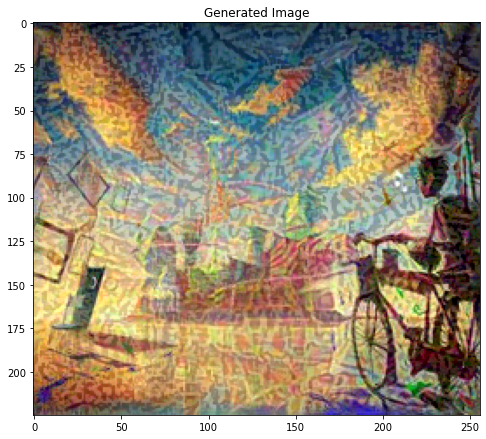

In [125]:
best, best_loss = style_transfer(content_path, style_path, 10, 1/1000, 1)

plt.figure(figsize=(8,8))
plt.title("Generated Image")
plt.imshow(best)
plt.show()